# Obligatorisk innlevering 2 - oppgave 1

Denne oppgaven tar for seg et datasett fra Food Mart, som er ennærbutikkjede i USA. Food Mart har i dette datasettet samlet endel data i forbindelse med mediekampanjer. Din oppgave er å forutsi kostnadene for mediekampanjer i matvaremarkedet på grunnlag av funksjonene som tilbys.

In [3]:
# Importer resten av pakkene du trenger her:
import pandas as pd
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn import datasets
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl

In [4]:
# I denne oppgaven skal dere bruke følgende datasett:
df = pd.read_csv("./datasett1.csv")
# Her deler jeg datasettet inn i egenskaper (X) og target (y)
X = df.iloc[:,:-1]
y = df.iloc[:,-1]
# Tilslutt deler jeg inn i et trening- og et testsett (75%/25%)
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.25, random_state=0)
# PS: Ikke endre denne kodecellen!

#### Oppgave 1.1) 
Visualiser $y\_train$ og $y\_test$ i et histogram. Kan du, basert på figuren, se hva slags problem vi skal løse (regresjon/klassifisering)? 

Begrunn svaret

In [5]:
#TODO: visualiser y_train og y_test i et histogram

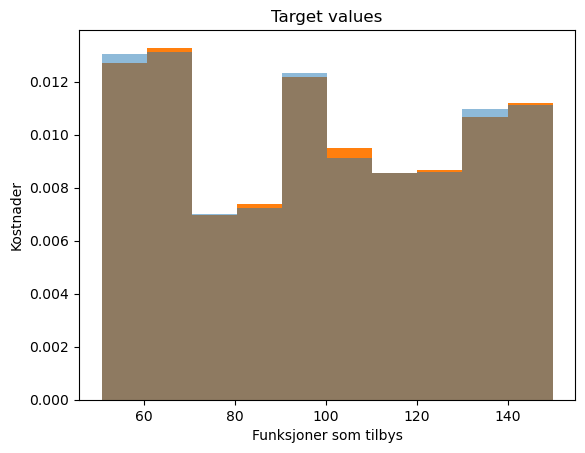

<Figure size 500x500 with 0 Axes>

In [6]:
plt.title("Target values")
plt.hist(y_train, density=True, color="C1", label="train")
plt.hist(y_test, density=True, color="C0", alpha=0.5, label="test")
plt.xlabel("Funksjoner som tilbys")
plt.ylabel("Kostnader")
plt.figure(figsize=(5,5))
plt.show() 

**Svar:**

* Y verdiene er kontinuerlige tall og dette tyder på at vi skal se på en lineærregresjonsoppgave.
* Hadde dataene i y_test og y_train representert diskrete kategorier eller klasser (farge, type bil, ja eller nei osv), kunne vi sagt at vi har en klassifiseringsoppgave

<span style='color:red '> Riktig! Histogrammet viser at vår target er en kontinuerlig variabel og derfor er det en regresjonsoppgave (men ikke nødvendigvis med bruk av lineære metoder) </span>

#### Oppgave 1.2) 

fullfør funksjonen under slik at den tar inn både egenskapene og target, legger disse sammen i samme matrise igjen og visualiser dataene som en korrelasjonsmatrise (poenget er at du skal kunne se hvordan egenskapene korrelerer med target).

* Beskriv hvilke egenskaper du ser korrelerer mest med target

In [7]:
def korrelasjonsmatrise(X,y):
    X_temp = X.copy()
    y_temp = y.copy()
    X_temp["Target"] = y_temp
    #TODO: Fullfør koden
    plt.figure(figsize=(50,50))
    sns.heatmap(X_temp.corr(), annot=True)
    plt.show()
    
    # Vi kan svare på spørsmålet visuelt men vi kan også skrive ut de sorterte egenskapene.
    absolute_verdier = abs(X_temp.corr()["Target"])
    sorterte_egenskaper = absolute_verdier.sort_values(ascending=False)
    # Her sorterte vi de absolute verdiene i synkende rekkefølge
    
    print("Egenskapene som korrelerer mest med target: ")
    print(sorterte_egenskaper)

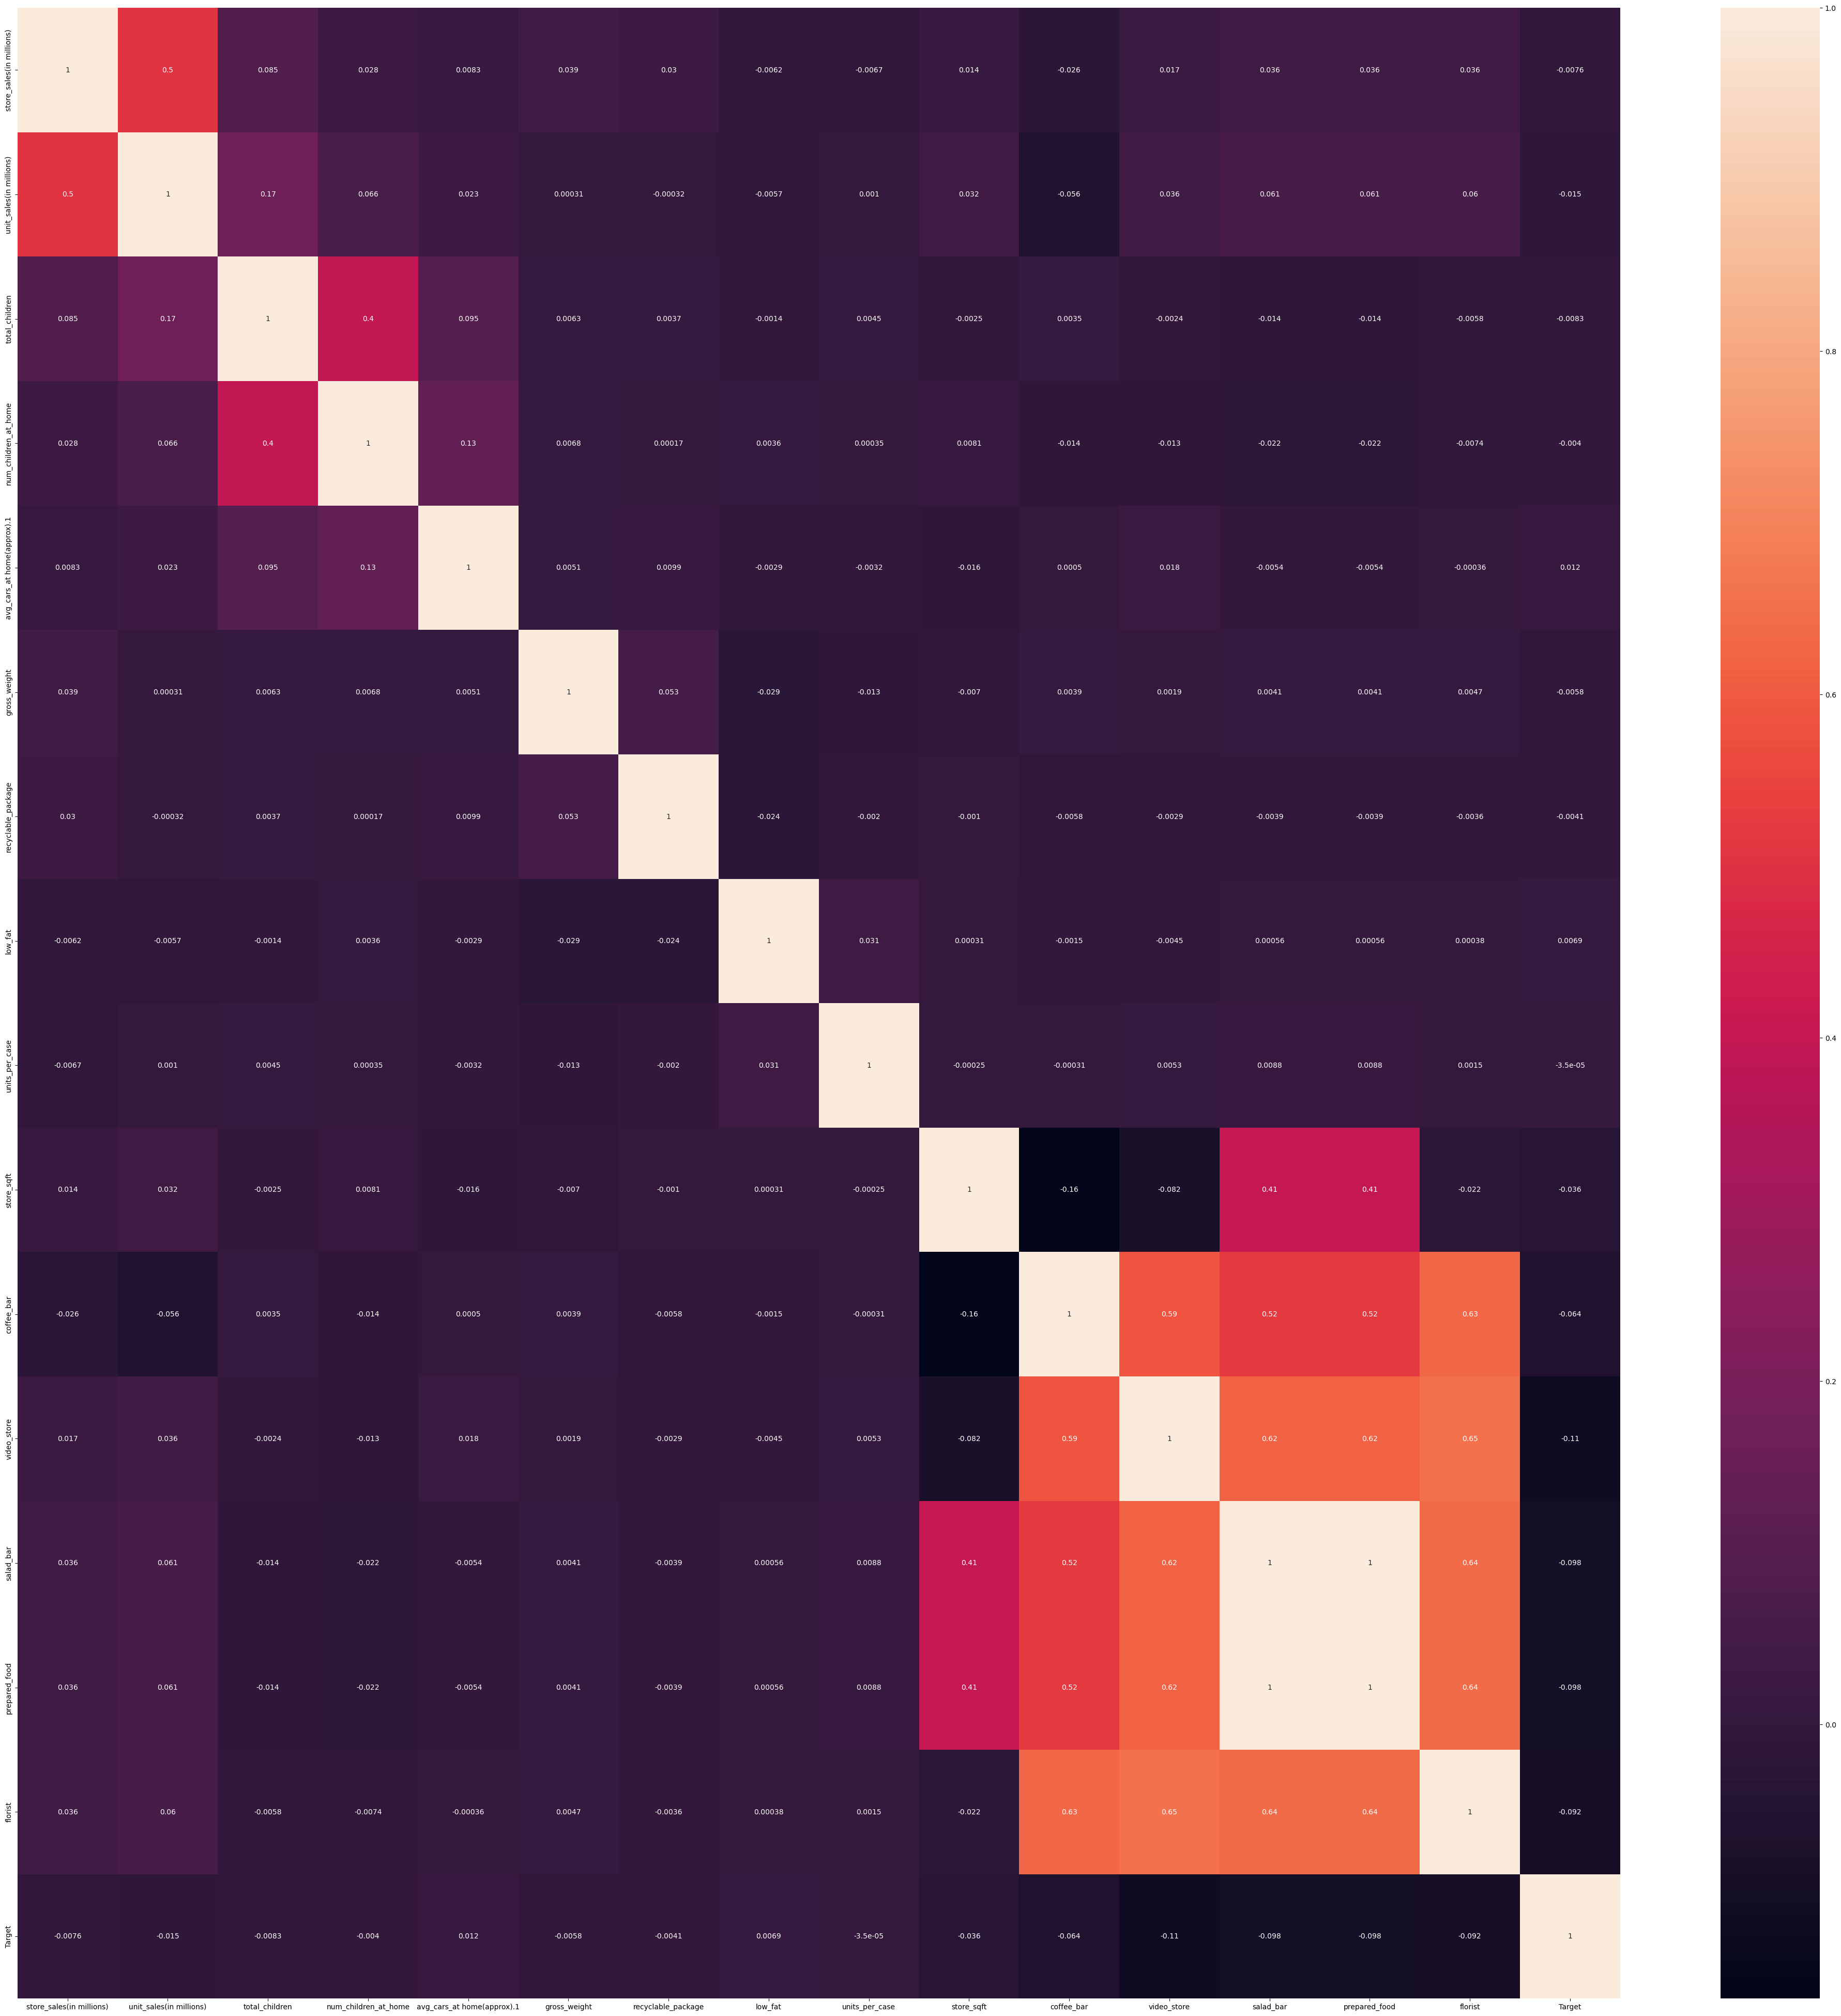

Egenskapene som korrelerer mest med target: 
Target                        1.000000
video_store                   0.114480
salad_bar                     0.097728
prepared_food                 0.097728
florist                       0.092241
coffee_bar                    0.064381
store_sqft                    0.035699
unit_sales(in millions)       0.015122
avg_cars_at home(approx).1    0.011515
total_children                0.008282
store_sales(in millions)      0.007580
low_fat                       0.006894
gross_weight                  0.005812
recyclable_package            0.004120
num_children_at_home          0.003972
units_per_case                0.000035
Name: Target, dtype: float64


In [8]:
korrelasjonsmatrise(X_train,y_train)

**Svar:**

*Følgende egenskaper korrelerer mest med target:*

- video_store                   0.114480
- salad_bar                     0.097728
- prepared_food                 0.097728
- florist                       0.092241


<span style='color:red '> Godt jobbet og oversiktlig løsning med liste over egenskapene som korrelerer mest. Nedenfor har jeg foreslått en metode som legger en "maske" over den ene diagonalen (dette fjerner redundant informasjon). </span>

In [11]:
def plot_correlation_matrix_suggested(X,y):
    X_copy = X.copy()
    X_copy["target"] = y
    plt.figure(figsize=(15,10))
    matrix = X_copy.corr()
    mask = np.zeros_like(matrix)
    mask[np.triu_indices_from(mask)] = True
    sns.heatmap(X_copy.corr(), annot=True, mask=mask)
    plt.show()

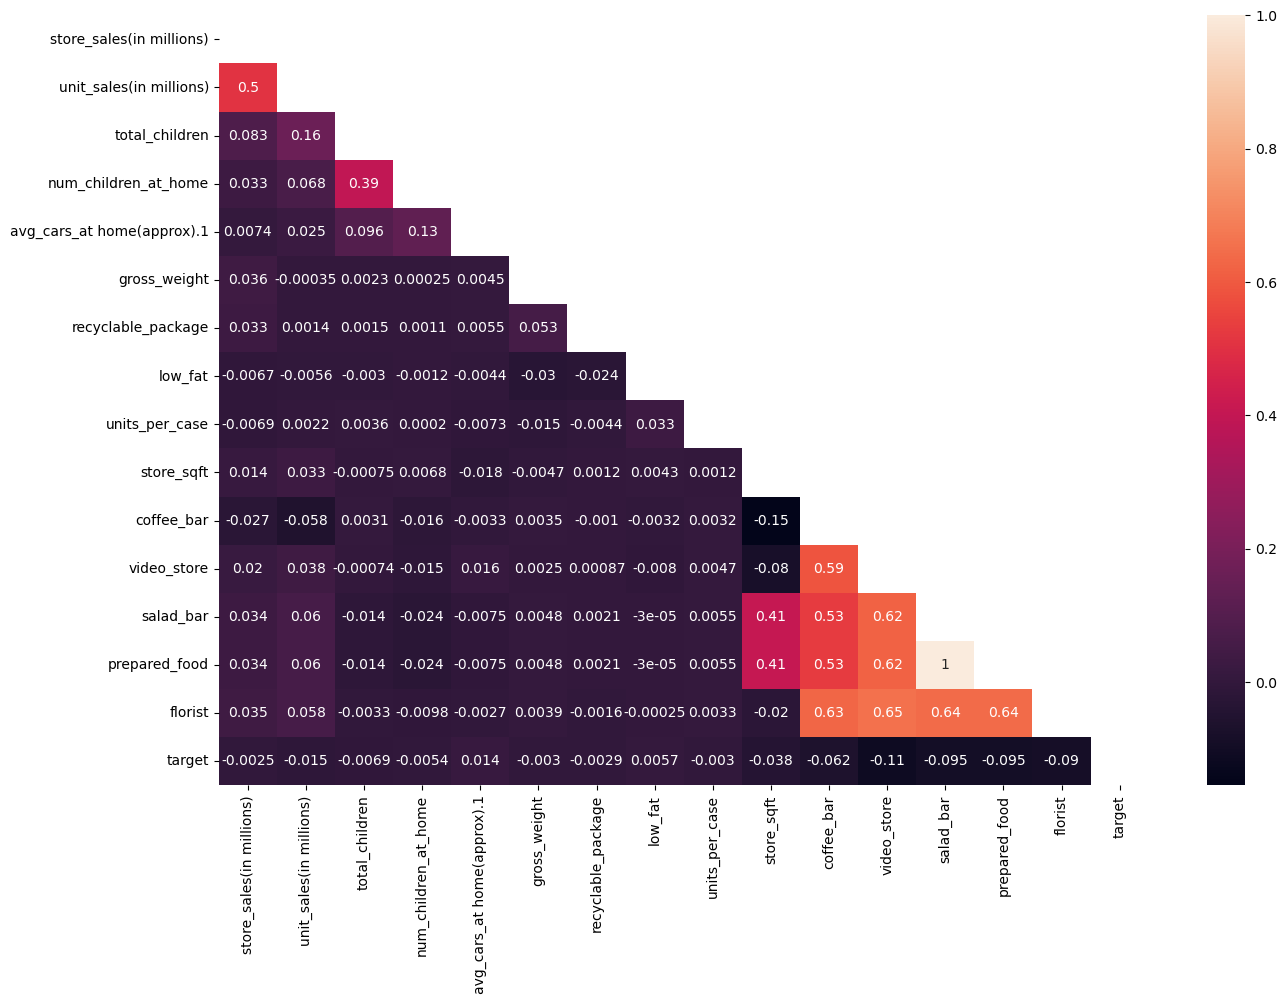

In [12]:
plot_correlation_matrix_suggested(X,y)

#### Oppgave 1.3) 
Velg en modellarkitektur (gjerne fra Scikit-Learn) og gjør et strukturert hyperparametersøk. 
* Gjør et søk på minst 3 paramtere og minst 2 verdier pr parameter
* Bruk 3-folds kryssvalidering for hver parameterkombinasjon
* Velg en metrikk som passer for målet (tips: "neg_mean_squared_error" i sklearn) 
* Skriv ut den parameterkobinasjonen som ga den beste skåren, samt skåren. Kommenter resultatet

In [13]:
# TODO: Utfør hyperparametersøk for en modell
# Navnene på trenings og testdata: X_train, X_test, y_train, y_test
X_train

,store_sales(in millions),unit_sales(in millions),total_children,num_children_at_home,avg_cars_at home(approx).1,gross_weight,recyclable_package,low_fat,units_per_case,store_sqft,coffee_bar,video_store,salad_bar,prepared_food,florist
34602,14.80,4.0,3.0,0.0,2.0,21.80,0.0,0.0,36.0,21215.0,1.0,0.0,0.0,0.0,0.0
2298,11.00,4.0,1.0,0.0,4.0,9.02,0.0,1.0,32.0,33858.0,1.0,0.0,1.0,1.0,1.0
47831,1.53,3.0,0.0,0.0,1.0,11.70,1.0,0.0,6.0,27694.0,1.0,1.0,1.0,1.0,1.0
2812,13.80,5.0,3.0,3.0,4.0,19.60,1.0,0.0,26.0,27694.0,1.0,1.0,1.0,1.0,1.0
36308,7.72,4.0,4.0,0.0,1.0,21.60,1.0,1.0,33.0,23688.0,1.0,1.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21243,11.24,4.0,3.0,0.0,2.0,10.70,0.0,0.0,9.0,23598.0,0.0,0.0,0.0,0.0,1.0
45891,8.49,3.0,3.0,0.0,3.0,20.20,0.0,1.0,27.0,23593.0,0.0,0.0,0.0,0.0,0.0
42613,6.68,4.0,3.0,0.0,2.0,18.10,0.0,0.0,30.0,23759.0,1.0,0.0,1.0,1.0,1.0
43567,6.92,2.0,2.0,2.0,3.0,14.70,0.0,0.0,36.0,33858.0,1.0,0.0,1.0,1.0,1.0


In [14]:
# Definer hyperparameter-grid
param_grid_lin_reg = {
    'fit_intercept': [True, False],  # å beregne intersept eller ikke
    'positive': [True, False],  
    'copy_X': [True, False],
    'n_jobs': [-1, 1, 2]  # antall kjerner brukt for beregning(-1 betyr bruk av alle tilgjenlige kjerner)
}

# Vi prøver å forutsi kostnader og derfor er det passelig med en lineær regresjon.
linreg = LinearRegression()

#Bruk 3-folds kryssvalidering for hver parameterkombinasjon
kf = KFold(n_splits=3, shuffle=True, random_state=0)


In [15]:
# Lager GridSearchCV regresjons objekt
search_linreg = GridSearchCV(estimator=linreg, param_grid=param_grid_lin_reg, scoring="neg_mean_squared_error", cv=kf)

# Prøve å tilpasse modellen til treningssettet
search_linreg.fit(X_train, y_train)

GridSearchCV(cv=KFold(n_splits=3, random_state=0, shuffle=True),
             estimator=LinearRegression(),
             param_grid={'copy_X': [True, False],
                         'fit_intercept': [True, False], 'n_jobs': [-1, 1, 2],
                         'positive': [True, False]},
             scoring='neg_mean_squared_error')

In [16]:
# Gjør et søk på minst 3 parametere og minst 2 verdier pr parameter

# Skriv ut den parameterkobinasjonen som ga den beste skåren, samt skåren. Kommenter resultatet

In [17]:
# Få den beste parameterkombinasjonen og scoren
best_params = search_linreg.best_params_
best_score = search_linreg.best_score_

# Skriv ut resultatet
print("Beste parameterkombinasjon:", best_params)
print("Beste score (neg_mean_squared_error):", best_score)


Beste parameterkombinasjon: {'copy_X': True, 'fit_intercept': True, 'n_jobs': -1, 'positive': False}
Beste score (neg_mean_squared_error): -886.349078827917


**Svar:**
**Skriv ut den parameterkobinasjonen som ga den beste skåren, samt skåren.**
* Beste parameterkombinasjon: {'copy_X': True, 'fit_intercept': True, 'n_jobs': -1, 'positive': False}
* Beste score (neg_mean_squared_error): -886.3490788279172


**Kommenter resultatet**
* Parameterkombinasjonen som ga best resultat under GridSearch er: copy_X : True, fit_intercept : True og n_jobs : -1 og positive: False
    * "copy_X : True" betyr at kopiering av X-train er tillatt. Dette kan være lurt for å kunne akselerere modelltrening. Ved kopiering av dataen kan man beholde integriteten til dataen og samtidig utføre beregninger på flere kopier av dataen.
    * "fit_intercept : True" betyr at modellen beregner intercept (verdien av y når x=0). Dette er vanlig for lineær regression.
    * "n_jobs : -1" betyr at linreg modellen bruker alle tigjengelig kjerner for beregninger.
    * "positive : False" betyr at både positive og negative korrelasjoner er akseptert. Koeffisientene representerer avhengigheten mellom uavhengige variabler og målvariabelen (kostnader for mediekampanjer i denne oppgaven). Noen er positive og andre negative. Det er viktig at begge er akseptert fordi både positiv og negativ korrelasjon kan tyde på en sammenheng. Ved å velge "positive : False" får modellen friheten til å velge koeffisientene som passer best til dataen, uavhengig om de er positive eller negative.
    
* Beste score (neg_mean_squared_error): -886.3490788279172
    * Dette måler hvor godt modellen predikerer markedsføringskostnader. Jo lavere "negative mean kvadratfeil" desto bedre er modellens ytelse. Vi har ikke noe benchmark å sammenligne med med -886 virker som en bra score. Det beste hadde vært om negative MSE er nærmere 0.
Kommentar til resultatet: 

Beste parameterkombinasjon: Den beste parameterkombinasjonen som ble funnet under grid-søket indikerer følgende:
'copy_X': True - Dette betyr at kopiering av X-data er aktivert, noe som kan være hensiktsmessig for å unngå uventede endringer i dataene.
'fit_intercept': True - Modellen beregner intercept (bias). Dette er vanlig for lineær regresjon, da intercept ofte er relevant.
'n_jobs': -1 - Modellen bruker alle tilgjengelige kjerner for beregninger, noe som kan bidra til å akselerere opplæringen.
'positive': False - Modellen er ikke begrenset til å ha positive koeffisienter.

Beste score (neg_mean_squared_error): Den beste negative middelkvadratfeilen (neg_mean_squared_error) som ble oppnådd med den beste parameterkombinasjonen, er -886.3490788279172. Dette er en måling av hvor godt modellen din utfører på kostnadsforutsigelse. Jo lavere denne verdien er, jo bedre er modellens ytelse.
Det ser ut til at modellen din oppnådde en negativ middelkvadratfeil som indikerer en relativt god ytelse på kostnadsforutsigelsen. Den valgte parameterkombinasjonen gir den beste ytelsen basert på den tilgjengelige parametergriden. Du kan bruke denne parameterkombinasjonen til å bygge den endelige lineære regresjonsmodellen for kostnadsforutsigelse.

<span style='color:red '>Strålende! Fin forklaring av samtlige parametre brukt i hyperparametersøket og tolkningen av deres effekt.  </span>

#### Oppgave 1.4) 
Bruk hyperparameterkombinasjonen fra oppgave 1.3 og kryssvalider den modellen på nytt med K >= 5 
* Logg "mean absolute error" og "mean squared error" for hver kryssvalideringsrunde
* Oppgi gjennomsnitt og standardavvik for "mean absolute error" og "mean squared error" etter kryssvalideringen og kommenter resultatet
* Hvor stor er den gjennomsnittlige feilen på prediksjonen sammenlignet med gjennomsnittlig faktisk pris i treningsdataene? 

**Beste parameterkombinasjon: {'copy_X': True, 'fit_intercept': True, 'n_jobs': -1, 'positive': False}**

**Beste score (neg_mean_squared_error): -886.3490788279172**

In [18]:
# Oppretter en array y_prediksjoner for å lagre target verdiene. 
# K-Fold cross-validation, med 7 K-folds.  

mae_values = [] # Lagringplass for verdiene
mse_values = []
    
kf = KFold(n_splits=7, shuffle=True, random_state=0)

neg_score_lin_reg = []

param_grid_lin_reg2 = {
    'fit_intercept': [True], 
    'positive': [False],  
    'copy_X': [True],
    'n_jobs': [-1] 
}
mae_list = []
mse_list = []

for i, (train_index, val_index) in enumerate(kf.split(X_train)):
    
    X_train_cv, X_val_cv = X_train.iloc[train_index], X_train.iloc[val_index]
    y_train_cv, y_val_cv = y_train.iloc[train_index], y_train.iloc[val_index]
    
    linreg2 = LinearRegression(fit_intercept = True, positive=False, copy_X=True, n_jobs=-1)
    linreg2.fit(X_train_cv, y_train_cv)
    # Bruker mean_absolute_error og mean_squared_error funksjonene fra scikit learn biblioteket

    y_val_hat = linreg2.predict(X_val_cv)
    mae = mean_absolute_error(y_val_cv,y_val_hat).round(2)
    mse = mean_squared_error(y_val_cv,y_val_hat).round(2)
 
    mae_list.append(mae)
    mse_list.append(mse)
    
# Skriver ut
print(f"Mean absolute error: {mae_list}")
print(f"Mean squared error: {mse_list}")

Mean absolute error: [25.89, 25.94, 25.31, 25.54, 25.81, 25.63, 25.69]
Mean squared error: [898.36, 894.36, 869.08, 877.94, 892.51, 885.34, 888.42]


In [19]:
# Oppgi gjennomsnitt og standardavvik for "mean absolute error" og "mean squared error" etter kryssvalideringen og kommenter resultatet
# Bruker numpy biblioteket for å regne på mean og std

average_mae_cv = np.mean(mae_list)
std_mae_cv = np.std(mae_list)
average_mse_cv = np.mean(mse_list)
std_mse_cv = np.std(mse_list)

# Print the results
print(f"Gjennomsnittlig MAE: {average_mae_cv:.2f}")
print(f"Standardavvik MAE: {std_mae_cv:.2f}")
print(f"Gjennomsnittlig MSE: {average_mse_cv:.2f}")
print(f"Standardavvik MSE: {std_mse_cv:.2f}")

Gjennomsnittlig MAE: 25.69
Standardavvik MAE: 0.20
Gjennomsnittlig MSE: 886.57
Standardavvik MSE: 9.41


**Svar**

*MAE : Den gjennomsnittlige absolutte feilen er ca 25.69. Dette er forskjellen mellom predikerte og virkelige priser i treningsdataene. Dette vil si at den virkelige verdiens avvik fra target er ca 25 dollar.*

*Standardavviket i MAE er på ca 0.20. Dette virker som et lite tall og betyr at MAE verdiene på tvers av de forskjellige valideringsrundene er konsekvente. Modellens prediksjon har konsistent nøyaktighet når det gjelder absolute error*

*MSE : Den gjennomsnittlige Mean Squared Error er på ca 886.57. Denne verdien representerer gjennomsnittet av kvadratforskjellene mellom modellens predikerte og virkelige priser i treningssettet. Større feil påvirker mer pga opphøyningen.*

*MSE : Standardavviket av MSE er på ca 9.41. På lik linje med standardavviket i MAE er dette er relativt lite tall. Dette tyder på at MSE verdiene gjennom kryssvalideringsrundene er konsistente.*

In [31]:
# Hvor stor er den gjennomsnittlige feilen på prediksjonen sammenlignet med gjennomsnittlig faktisk pris i treningsdataene?
# Gjennomsnittlig faktisk pris i treningsdataene
avg_actual_price = np.mean(y_train)

# Beregn MAE som prosentandel av gjennomsnittlig faktisk pris
mae_as_percentage_of_actual_price = (average_mae_cv / avg_actual_price) * 100

# Skriv ut resultatet. Avrunder til nærmeste 2 desimaler
print(f"Gjennomsnittlig feil på prediksjonen sammenlignet med gjennomsnittlig faktisk pris: {mae_as_percentage_of_actual_price:.2f}%")

Gjennomsnittlig feil på prediksjonen sammenlignet med gjennomsnittlig faktisk pris: 25.86%


<span style='color:red '>Veldig bra!</span>

#### Oppgave 1.5) 
Tren modellen en siste gang på alle treningsdataene og gjør prediksjon på testdataene (bruk de optimale parametrene fra oppgave 1.3)
* Hvor stor er den gjennomsnittlige feilen på prediksjonen sammenlignet med gjennomsnittlig faktisk pris i testdataene? 

In [20]:
# TODO: Tren modellen på alle treningsdata og utfør prediksjon på testdataene
# Fra 1.3 : Beste parameterkombinasjon: {'copy_X': True, 'fit_intercept': True, 'n_jobs': -1, 'positive': False}

# Definer hyperparameter-grid
param_grid_lin_reg2 = {
    'fit_intercept': [True], 
    'positive': [False],  
    'copy_X': [True],
    'n_jobs': [-1] 
}

linreg2 = LinearRegression()

search_linreg2 = GridSearchCV(estimator=linreg2, param_grid=param_grid_lin_reg2, scoring="neg_mean_squared_error", cv=kf)

search_linreg2.fit(X_train, y_train)

# Gjør prediksjon på testdataene
y_pred_test = search_linreg2.predict(X_test)
print(y_pred_test)

[102.30294576  94.73511503 103.91270684 ... 100.93182966 100.79482176
 100.84887096]


In [21]:
# Hvor stor er den gjennomsnittlige feilen på prediksjonen sammenlignet med gjennomsnittlig faktisk pris i 
# testdataene? Vi må finne ut Mean Absolutt Error først. Og så dele på gj.snitt av de virkelige prisene

# Beregn MAE på test prediksjonen y_pred_test
mae_test = mean_absolute_error(y_test, y_pred_test)

# Vi har allerede beregnet gjennomsnittlig faktisk pris i trenings dataene. Nå gjør vi det samme for testdata
avg_actual_price_test = np.mean(y_test)

# Regner på gjennomsnittet
snitt_mae = mae_test / avg_actual_price_test

print(f"Gjennomsnittlig feil på prediksjonen, sammenlignet med gj.snittlig faktisk pris: {snitt_mae:.2%}")

Gjennomsnittlig feil på prediksjonen, sammenlignet med gj.snittlig faktisk pris: 25.98%


**Svar:**

*Gjennomsnittlig feil på prediksjonen, sammenlignet med gjennomsnittlig faktisk pris: 25.86% (treningsdata)*

*Gjennomsnittlig feil på prediksjonen, sammenlignet med gjennomsnittlig faktisk pris: 25.98% (testdata)*

*Forskjellen mellom de to er ganske liten og det virker at treningsdataene er representativ for hele datasettet. Allikevel er en MAE på 25% ganske mye når man snakker om kostnadsprediksjon"

<span style='color:red '>Riktig! Fornuftig konklusjon  </span>